# BARCELONA PROVINCE REAL ESTATE DATA ANALYSIS

Spain is a diverse country with Barcelona as it's most famous province known for its outstanding football team, stunning architecture, lively nightlife, sandy beaches, and world-class cuisine. Not to mention a vibrant cultural heritage and colourful neighbourhood festivals that attract visitors and settlers  from around the world. Hence, this project entails the the Analysis of prices of house in Barcelona province scrapped from www.thinkspain.com real estate website, which provides answer to the following questions. 
       “How much should this house cost?"
       "How can we better estimate prices?”


# Content.

1 Import Library

2 Web Scrapping

3 Data Cleaning

4 Data Exploration

5 Model Analysis

# 1. Import Library

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from kneed import KneeLocator
import string
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim
import nltk
from nltk import ngrams
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Common Lematizer
from nltk.corpus import wordnet
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Web Scrapping

Web scraping (or data scraping) is a technique used to collect content and data from the internet. 
For the purpose of this project i scrape data on houses for sale from www.thinkspain.com on the 11th of August. I concentrated on data from houses that has details on Bedroom, Bathroom, Building size and plot of land size and skip data on house that doesn't have details for this 4 variables for uniformity sake. All of this data was extracted from the  very first web page of various locations within Barcelona province

In [ ]:
# The website link
url = "https://www.thinkspain.com/property-for-sale/barcelona"
# Making the request look like a normal browser
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'} 
# Requesting the sites content
page = requests.get(url,headers=headers)
soup = BeautifulSoup(page.content, "html.parser")

#getting all province in Barcelona 
province_location = []
province_link = []
province_details = soup.find_all("ul", class_="city-list")

for detail in  province_details:
    province_location.append(detail.get_text().lstrip())
    province_link.append(detail.get("href"))
province_location = province_location[1].split("\n")

province_link_details = soup.find_all("a", class_="twc__map-search-update-link twc__aggregation-link disable-child-touch")
for detail in province_link_details:
    province_link.append(detail.get("href"))
province_link = province_link[4:]


#getting individual house details

Province_locations = []
Building_Size = []
Bedroom = []
Bathroom = []
Plot_of_Land = []
Price = []
Address = []
Description = []


for link in province_link:
    province_url = f"https://www.thinkspain.com{link}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'} 
    page = requests.get(province_url,headers=headers)
    province_soup = BeautifulSoup(page.content, "html.parser")
     
    description_links= []
    property_descriptions = province_soup.find_all("a",  class_="property-link property__readmore")     
  
    for property_description in property_descriptions:
        description_links.append(property_description.get("href"))
    for  description_link in description_links:
        house_description_url = f"https://www.thinkspain.com{description_link}"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'} 
        description_page = requests.get(house_description_url,headers=headers)
        house_description_soup = BeautifulSoup(description_page.content, "html.parser")
        
        details = house_description_soup.find_all("ul", class_="detail-list")
        house_details = []
        houses_to_clean = []
        
        
        for detail in details:
            house_details.append(detail.get_text().strip())
        for house_detail in house_details:
            houses_to_clean.append(house_detail.split("\n\n\n\n\n"))
        if len(houses_to_clean[0]) == 5:
            
            Price.append(houses_to_clean[0][0].strip())
            
            Building_Size.append(houses_to_clean[0][1].strip())
            Bedroom.append(houses_to_clean[0][2].strip())
            Bathroom.append(houses_to_clean[0][3].strip())
            Plot_of_Land.append(houses_to_clean[0][4].strip())            
       
            descriptions = house_description_soup.find_all("p", class_="property-description" )
            for description in descriptions:
                Description.append(description.get_text().strip())
             
            province_locations = house_description_soup.find_all("span", class_="locationProximity")
            for province_location in province_locations:
                Province_locations.append(province_location.get_text().strip())
             
            addresses = house_description_soup.find_all("h1",class_="h1 bold mt-none pb-none mb-none")
            for address in addresses:
                Address.append(address.get_text().strip())
            
        else:
            pass
            
            

In [69]:
#converting the data in the various list to a pandas dataframe
data = pd.DataFrame({  
                     'Barcelona_province_locations':Province_locations,
                     'Bedroom':Bedroom,
                     'Bathroom':Bathroom,
                     'Building_Size':Building_Size,
                     'Plot_of_Land':Plot_of_Land,
                     'Price':Price,
                     'Address':Address,
                     'Description':Description
                  
               
                  })
df

,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description
0,"Alella, Barcelona",4,3,373 m2,1118 m2,"€ 1,790,000","Villa for sale in Alella, Barcelona",This 373sq m modern house completely renovated...
1,"Alella, Barcelona",6,5,639 m2,1265 m2,"€ 1,600,000","Villa for sale in Alella, Barcelona",Located in the exclusive Can Teixido residenti...
2,"Alella, Barcelona",4,2,245 m2,540 m2,"€ 630,000","Villa for sale in Alella, Barcelona",The house is located in the upper part of Alel...
3,"Alella, Barcelona",3,4,604 m2,1500 m2,"€ 2,500,000","Villa for sale in Alella, Barcelona",The luxurious mansion is located in a unique l...
4,"Alella, Barcelona",5,5,500 m2,1100 m2,"€ 1,325,000","Villa for sale in Alella, Barcelona",Villa in a prestigious urbanization of Alella ...
...,...,...,...,...,...,...,...,...
289,"Sant Cugat del Vallès, Barcelona",5,6,850 m2,700 m2,"€ 2,600,000","Townhouse for sale in Sant Cugat del Vallès, B...",Exclusive and design property nearby the Sant ...
290,"Valldoreix, Sant Cugat del Vallès, Barcelona",5,4,1192 m2,2500 m2,"€ 2,650,000","Townhouse for sale in Valldoreix, Sant Cugat d...",Magnificent property with spectacular garden a...
291,"Sant Cugat del Vallès, Barcelona",5,6,498 m2,627 m2,"€ 2,125,000","Villa for sale in Sant Cugat del Vallès, Barce...",Lucas Fox International Properties presents th...
292,"Sant Cugat del Vallès, Barcelona",4,3,380 m2,400 m2,"€ 1,170,000","Villa for sale in Sant Cugat del Vallès, Barce...",This project offers the opportunity to design ...


# 3. Data Cleaning

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Barcelona_province_locations  294 non-null    object
 1   Bedroom                       294 non-null    int64 
 2   Bathroom                      294 non-null    int64 
 3   Building_Size                 294 non-null    object
 4   Plot_of_Land                  294 non-null    object
 5   Price                         294 non-null    object
 6   Address                       294 non-null    object
 7   Description                   294 non-null    object
dtypes: int64(2), object(6)
memory usage: 18.5+ KB


In [3]:
#remove the "€" from price and convert the column to an int 
df['Price'] = df['Price'].astype(str)
df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].str.replace('€', '')
df['Price'] = df['Price'].astype(int)
                                    
#remove the "m2" from building size and convert the column to an int
df['Building_Size'] = df['Building_Size'].astype(str)
df['Building_Size'] = df['Building_Size'].str.replace('m2', '')
df['Building_Size'] = df['Building_Size'].astype(int)

#remove the "m2" from Plot_of_Land and convert the column to an int
df['Plot_of_Land'] = df['Plot_of_Land'].astype(str)
df['Plot_of_Land'] = df['Plot_of_Land'].str.replace('m2', '')
df['Plot_of_Land'] = df['Plot_of_Land'].astype(int)

df.head()

,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description
0,"Alella, Barcelona",4,3,373,1118,1790000,"Villa for sale in Alella, Barcelona",This 373sq m modern house completely renovated...
1,"Alella, Barcelona",6,5,639,1265,1600000,"Villa for sale in Alella, Barcelona",Located in the exclusive Can Teixido residenti...
2,"Alella, Barcelona",4,2,245,540,630000,"Villa for sale in Alella, Barcelona",The house is located in the upper part of Alel...
3,"Alella, Barcelona",3,4,604,1500,2500000,"Villa for sale in Alella, Barcelona",The luxurious mansion is located in a unique l...
4,"Alella, Barcelona",5,5,500,1100,1325000,"Villa for sale in Alella, Barcelona",Villa in a prestigious urbanization of Alella ...


In [14]:
df.describe()

,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price
count,294.00000,294.000000,294.000000,2.940000e+02,2.940000e+02
mean,8.35034,5.639456,575.445578,3.633232e+04,1.300910e+06
std,15.00090,8.509738,572.382669,1.496962e+05,1.287019e+06
min,2.00000,1.000000,54.000000,5.500000e+01,7.200000e+04
25%,4.00000,3.000000,238.000000,5.000000e+02,4.992500e+05
50%,5.00000,4.000000,400.000000,9.570000e+02,8.940000e+05
75%,6.00000,5.000000,603.000000,2.119250e+03,1.698750e+06
max,80.00000,45.000000,5000.000000,1.400000e+06,8.900000e+06


# 4. Data Exploration

In this section, the aim was to explore and make adjustments to the data for further analysis. I also made use of MatPlotlib to visualize some task in this section.

## location geocoding

For my final dashboard, I want to add a map that shows the various locations  houseins within  the province, to do that, Tableau needs basic geographic information. To further retrive my longitude and Latitude data, I made use of GEOPY, a library in python that takes a country name as input and produce the corresponding longitude and Latitude as output.


In [5]:
#create an empty list that will house all the unique country name 
Barcelona_province = []
for location in df["Barcelona_province_locations"]:
    Barcelona_province.append(location)

#an empty list to house all the Longitude and Latitude details
Longitude = []
Latitude = []

#geolocator for the each location longitude and Latitude details
geolocator = Nominatim(user_agent="MyApp")

for location in Barcelona_province:
    location = geolocator.geocode(location)
    Longitude.append(location.longitude)
    Latitude.append(location.latitude)
    
#create a longitude and latitude column in the dataset
df["Longitude"] = Longitude
df["Latitude"] = Latitude
df

,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description,Longitude,Latitude
0,"Alella, Barcelona",4,3,373,1118,1790000,"Villa for sale in Alella, Barcelona",This 373sq m modern house completely renovated...,2.294276,41.495287
1,"Alella, Barcelona",6,5,639,1265,1600000,"Villa for sale in Alella, Barcelona",Located in the exclusive Can Teixido residenti...,2.294276,41.495287
2,"Alella, Barcelona",4,2,245,540,630000,"Villa for sale in Alella, Barcelona",The house is located in the upper part of Alel...,2.294276,41.495287
3,"Alella, Barcelona",3,4,604,1500,2500000,"Villa for sale in Alella, Barcelona",The luxurious mansion is located in a unique l...,2.294276,41.495287
4,"Alella, Barcelona",5,5,500,1100,1325000,"Villa for sale in Alella, Barcelona",Villa in a prestigious urbanization of Alella ...,2.294276,41.495287
...,...,...,...,...,...,...,...,...,...,...
289,"Sant Cugat del Vallès, Barcelona",5,6,850,700,2600000,"Townhouse for sale in Sant Cugat del Vallès, B...",Exclusive and design property nearby the Sant ...,2.081781,41.472843
290,"Valldoreix, Sant Cugat del Vallès, Barcelona",5,4,1192,2500,2650000,"Townhouse for sale in Valldoreix, Sant Cugat d...",Magnificent property with spectacular garden a...,2.050516,41.459907
291,"Sant Cugat del Vallès, Barcelona",5,6,498,627,2125000,"Villa for sale in Sant Cugat del Vallès, Barce...",Lucas Fox International Properties presents th...,2.081781,41.472843
292,"Sant Cugat del Vallès, Barcelona",4,3,380,400,1170000,"Villa for sale in Sant Cugat del Vallès, Barce...",This project offers the opportunity to design ...,2.081781,41.472843


## Outliers 

Outliers are data points in a dataset that are considered to be extreme, false, or not representative of what the data is describing. These outliers can be caused by either incorrect data collection or genuine outlying observations. Removing these outliers will often help our model to generalize better as these long tail observations could skew the learning.

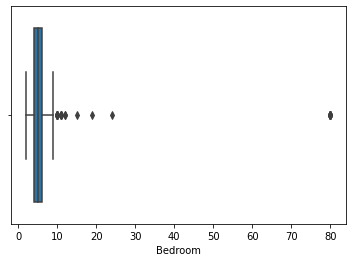

In [5]:
#using box plot to visualize outliers in our data 
sns.boxplot(x=df['Bedroom'])
plt.show()

## Detecting Outliers

For this project I'm going to use the Interquartile Range Method for my Outliers remover 

The interquartile range approach first calculates the interquartile range (IQR) of the data. The IQR is defined as the difference between the 75 and 25 percentile of a variable. This IQR is then multiplied with 1.5. Any data that is then further away than the 75 percentile plus 1.5*IQR or 25 percentile minus 1.5*IQR is classified as an outlier.

In [5]:
Q1 = df["Bedroom"].quantile(0.25)
Q3 = df["Bedroom"].quantile(0.75)
IQR = Q3 -Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(1.0, 9.0)

Hence any row with  bedroom less than 1 or greater than 9 will be considered as an outlier, from the nature of the project, it is uncommon for an average residential house to have more than 9 Bedroom

In [11]:
#outliers from our original dataset
df[(df["Bedroom"]<lower_limit)|(df["Bedroom"]>upper_limit)]

,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description
33,"Begues, Barcelona",11,7,581,6500,2300000,"Villa for sale in Begues, Barcelona",Exclusive villa for sale in the Can Amell de B...
38,"Sabadell, Barcelona",80,45,1950,500,3000000,"Townhouse for sale in Sabadell, Barcelona",For sale in the city center of the province of...
41,"Borredà, Barcelona",11,12,950,1650,875000,"Finca/Country House for sale in Borredà, Barce...",Country house from the 14th century of 950 m2 ...
42,"Borredà, Barcelona",10,8,2000,520000,1700000,"Finca/Country House for sale in Borredà, Barce...",In this idyllic setting and just 1 hour from B...
46,"Borredà, Barcelona",11,12,950,1650,875000,"Finca/Country House for sale in Borredà, Barce...",Country house from the 14th century of 950 m2 ...
47,"Borredà, Barcelona",10,8,2000,520000,1700000,"Finca/Country House for sale in Borredà, Barce...",In this idyllic setting and just 1 hour from B...
48,"Ripoll, Girona",19,23,5000,600000,4750000,"Finca/Country House for sale in Ripoll, Girona",Spectacular farmhouse dating back to the 19th ...
58,"Cabrera de Mar, Barcelona",11,4,517,1732,1500000,Finca/Country House for sale in Cabrera de Mar...,"Located in the municipality of Cabrera de Mar,..."
66,"Cabrils, Barcelona",10,8,1270,6760,4200000,"Villa for sale in Cabrils, Barcelona",This fantastic luxury villa was built in 1980 ...
69,"Cabrils, Barcelona",11,5,1000,90654,1800000,"Villa for sale in Cabrils, Barcelona",Lucas Fox presents this charming farmhouse fro...


In [6]:
#data set without outliers
df_clean = df[(df["Bedroom"]>lower_limit)&(df["Bedroom"]<upper_limit)]
df_clean.head()

,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description
0,"Alella, Barcelona",4,3,373,1118,1790000,"Villa for sale in Alella, Barcelona",This 373sq m modern house completely renovated...
1,"Alella, Barcelona",6,5,639,1265,1600000,"Villa for sale in Alella, Barcelona",Located in the exclusive Can Teixido residenti...
2,"Alella, Barcelona",4,2,245,540,630000,"Villa for sale in Alella, Barcelona",The house is located in the upper part of Alel...
3,"Alella, Barcelona",3,4,604,1500,2500000,"Villa for sale in Alella, Barcelona",The luxurious mansion is located in a unique l...
4,"Alella, Barcelona",5,5,500,1100,1325000,"Villa for sale in Alella, Barcelona",Villa in a prestigious urbanization of Alella ...


In [10]:
df_clean.describe()

,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price
count,255.000000,255.000000,255.000000,255.000000,2.550000e+02
mean,4.678431,3.556863,427.545098,18859.062745,1.158272e+06
std,1.238540,1.615532,341.867654,90230.551809,1.250727e+06
min,2.000000,1.000000,54.000000,55.000000,7.200000e+04
25%,4.000000,2.000000,223.500000,500.000000,4.450000e+05
50%,5.000000,3.000000,377.000000,902.000000,7.950000e+05
75%,5.000000,5.000000,509.500000,1979.500000,1.465000e+06
max,8.000000,9.000000,2274.000000,726000.000000,8.900000e+06


## Natural Language Processing Sentiment Analysis

Natural language processing (NLP)is a field that focuses on making natural human language usable by computer programs

In this section,I Analyze and made exploring  Analysis on each house advertisement descriptions using NLP pre-processing and visualization techniques.

In [7]:
#convert text to lower case 
df_clean["Description_new_text"]= df_clean["Description"].str.lower()
#remove these special characters from the description
df_clean["Description_new_text"] = df_clean["Description_new_text"].str.replace(r'[^A-Za-z0-9 ]+', ' ')
#tokenization(The process of extracting individual words)
nltk.download('punkt')
Tokenized_words = []
for each_description in df_clean["Description_new_text"]:
    Tokenized_words.append(word_tokenize(each_description))
#remove stopwords
#stopwords(This are words that occur very frequently in the English language without adding any context specific insights to our text)
nltk.download('stopwords')
noise_words=[]
eng_stop_words = stopwords.words('english')
stop_words = set(eng_stop_words)
#now, we will remove the stop words from our description
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]
df_clean['Description_text_nonstop'] = df_clean['Description_new_text'].apply(lambda row: stopwords_removal(stop_words, row))
#lemmatization(This is used to reduce words to their root)
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]    
df_clean['Description_text_lemmatize'] = df_clean['Description_text_nonstop'].apply(lambda row: lemmatize_terms(row))
df_clean[['Description_text_lemmatize','Description_text_nonstop','Description_new_text']]

/data/user/0/ru.iiec.pydroid3/cache/ipykernel_30201/2133602195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Description_new_text"]= df_clean["Description"].str.lower()
/data/user/0/ru.iiec.pydroid3/cache/ipykernel_30201/2133602195.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["Description_new_text"] = df_clean["Description_new_text"].str.replace(r'[^A-Za-z0-9 ]+', ' ')
/data/user/0/ru.iiec.pydroid3/cache/ipykernel_30201/2133602195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,Description_text_lemmatize,Description_text_nonstop,Description_new_text
0,"[373sq, modern, house, completely, renovated, ...","[373sq, modern, house, completely, renovated, ...",this 373sq m modern house completely renovated...
1,"[located, exclusive, teixido, residential, are...","[located, exclusive, teixido, residential, are...",located in the exclusive can teixido residenti...
2,"[house, located, upper, part, alella, enjoys, ...","[house, located, upper, part, alella, enjoys, ...",the house is located in the upper part of alel...
3,"[luxurious, mansion, located, unique, location...","[luxurious, mansion, located, unique, location...",the luxurious mansion is located in a unique l...
4,"[villa, prestigious, urbanization, alella, tei...","[villa, prestigious, urbanization, alella, tei...",villa in a prestigious urbanization of alella ...
...,...,...,...
289,"[exclusive, design, property, nearby, sant, cu...","[exclusive, design, property, nearby, sant, cu...",exclusive and design property nearby the sant ...
290,"[magnificent, property, spectacular, garden, m...","[magnificent, property, spectacular, garden, m...",magnificent property with spectacular garden a...
291,"[lucas, fox, international, property, present,...","[lucas, fox, international, properties, presen...",lucas fox international properties presents th...
292,"[project, offer, opportunity, design, ideal, h...","[project, offers, opportunity, design, ideal, ...",this project offers the opportunity to design ...


## n-gram

N-grams are token groups of n words that commonly appear together in a document or corpus. A unigram is just one single word, a bigram contains 2-word groupings, and so on. N-grams help us quickly identify the most important words and terms in our corpus.

In [7]:
Words = []
for texts in df_clean['Description_text_lemmatize']:
    for text in texts:
        Words.append(text)
#top 20 words of each n grams      
unigrams_series = (pd.Series(nltk.ngrams(Words, 1)).value_counts(ascending=False))[:20]
bigrams_series = (pd.Series(nltk.ngrams(Words, 2)).value_counts(ascending=False))[:20]
trigrams_series = (pd.Series(nltk.ngrams(Words, 3)).value_counts(ascending=False))[:20]        

Text(0.5, 0, 'Unigram')

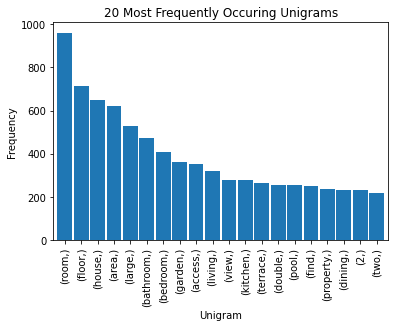

In [41]:
unigrams_series.plot.bar(width=0.9)
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Frequency')
plt.xlabel('Unigram')

Text(0.5, 0, 'Bigram')

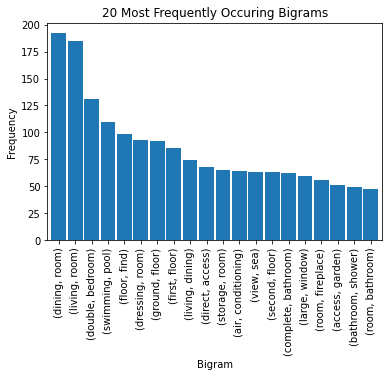

In [122]:
bigrams_series.plot.bar( width=.9)
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Frequency')
plt.xlabel('Bigram')

Text(0.5, 0, 'Trigram')

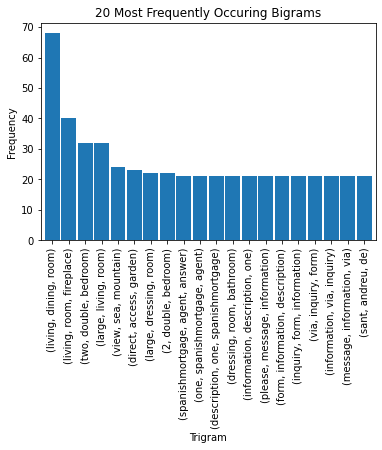

In [123]:
trigrams_series.plot.bar( width=.9)
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Frequency')
plt.xlabel('Trigram')

The most common uni-, bi- and tri-grams are “room", “dining”  “living" , "bathroom”. These are all typical real estate-focused words, and many of them are likely not going to help us in  our model’s prediction of price.

After looking at my initial visualisations, i decided to add the following steps in my text pre-processing pipeline:

In [8]:
#Removing additional real estate-specific stop words, like those listed here:
real_estate_stopwords = [
    "area",
    "province",
    "location",
    "plot",
    "hectare",
    "m²",
    "m2",
    "sq",
    "sale",
    "square",
    "meter",
    "bedroom",
    "bathroom",
    "room",
    "living",
    "kitchen",
    "hallway",
    "corridor",
    "dining",
    "pool",
    "apartment",
    "flat",
    "floor",
    "two",
    "house"
    ]
           # REPEAT PROCESS
#now, we will remove the Real Estate stop words from our description
stop_words = set(real_estate_stopwords)
def real_estate_stopwords_removal(stop_words, sentence):
    return [word for word in sentence if word not in stop_words]
df_clean['Description_text_lemmatize'] = df_clean['Description_text_lemmatize'].apply(lambda row: real_estate_stopwords_removal(stop_words, row))

#n-gram
Words = []
for texts in df_clean['Description_text_lemmatize']:
    for text in texts:
        Words.append(text)
#top 20 words of each n grams      
unigrams_series = (pd.Series(nltk.ngrams(Words, 1)).value_counts(ascending=False))[:20]
bigrams_series = (pd.Series(nltk.ngrams(Words, 2)).value_counts(ascending=False))[:20]
trigrams_series = (pd.Series(nltk.ngrams(Words, 3)).value_counts(ascending=False))[:20]     

/data/user/0/ru.iiec.pydroid3/cache/ipykernel_30201/270410853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Description_text_lemmatize'] = df_clean['Description_text_lemmatize'].apply(lambda row: real_estate_stopwords_removal(stop_words, row))


Text(0.5, 0, 'Unigram')

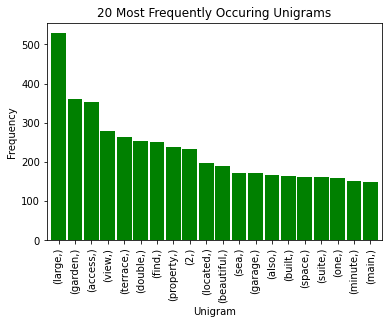

In [14]:
unigrams_series.plot.bar(color="green", width=0.9)
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Frequency')
plt.xlabel('Unigram')

Text(0.5, 0, 'Bigram')

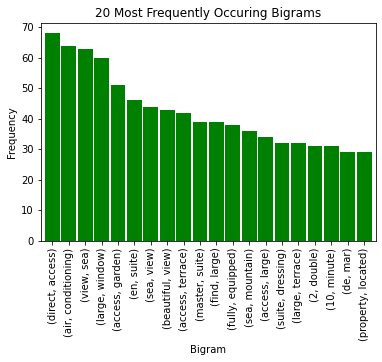

In [9]:
bigrams_series.plot.bar(color="green", width=0.9)
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Frequency')
plt.xlabel('Bigram')

Text(0.5, 0, 'Trigram')

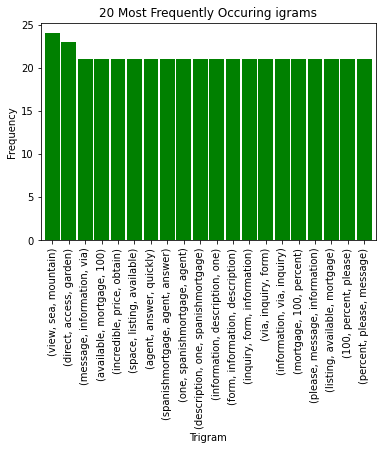

In [10]:
trigrams_series.plot.bar(color="green", width=.9)
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Frequency')
plt.xlabel('Trigram')

After adding these steps to our pre-processing pipeline, the n-grams became much more interesting:
The bigrams and trigrams are no longer dominated by words like bedroom and bathroom. They now contain price-relevant terms like “sea view”, “mountain", and "garden” .

## Word Cloud

A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

In this section, I did a world cloud view on the entire description text column , also did another on the 10  least expensive houses and another on the 10 most expensive houses


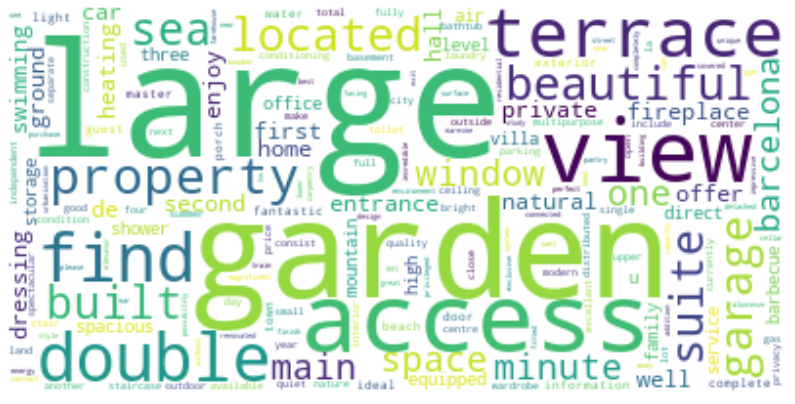

In [55]:
#entire description column
WORD = []
for words in df_clean['Description_text_lemmatize']:
    for word in words:
        WORD.append(word)        
#Creating the text variable
text = " ".join(WORD)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

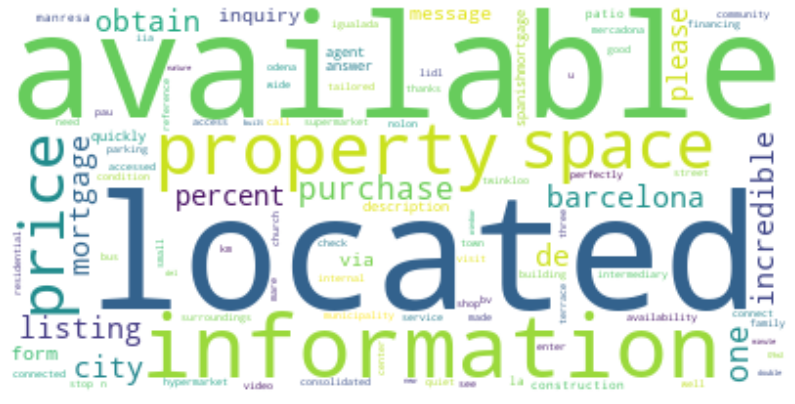

In [63]:
#least expensive houses
df_poor = df_clean.sort_values(by=['Price'])[:10]

WORD = []
for words in df_poor['Description_text_lemmatize']:
    for word in words:
        WORD.append(word)        
#Creating the text variable
text = " ".join(WORD)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

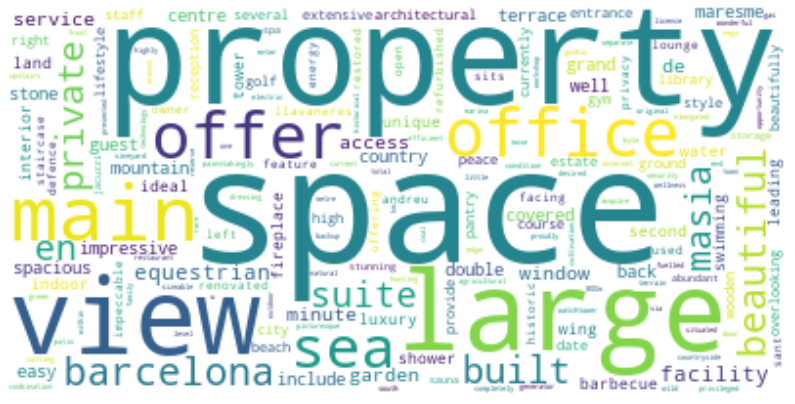

In [64]:
# most expensive houses
df_rich = df_clean.sort_values(by=['Price'], ascending=False)[:10]

WORD = []
for words in df_rich['Description_text_lemmatize']:
    for word in words:
        WORD.append(word)        
#Creating the text variable
text = " ".join(WORD)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

we can clearly see a stark difference in the most common words.
In the expensive houses, we have words like  view, sea, space, office, all of this words are the characteristics of an expensive house and this are not found in the least expensive house above

# 5 Model Analysis

In this section, we are going to predict Price of houses base on different variable that could influence the  price.

A Model can be thought of as a mathematical equation used to predict value given one or more other value.


## Machine Learning Algorithm (k-Means)

k-means is an Unsupervised Machine Learning algorithm that groups data into k number of clusters. This method uses a centroid based algorithm to group the houses into “k” clusters such that all houses with similar characteristics or qualities are in the same cluster. The algorithm works in the following steps:
  
   Determine most optimal k (i.e. no    of clusters)
   
   Initialize k such that initial      means are randomly generated        within the data domain
   
   k clusters are created by            associating every observation        with the nearest mean
      
   The centroid of each of the k        clusters becomes the new mean
   
   Steps (iii and iv) are repeated      until convergence is reached such    that all data points belong to a    cluster that are significantly      distinct from one another

## Determining Optimum number of Clusters (Elbow Method)

For this method, the dataset is fit with the k-means model for a range of values (1-10). The distortions for each value of k is stored and then plotted on a line chart. The point of inflection is a good indication that the model fits best at that point.


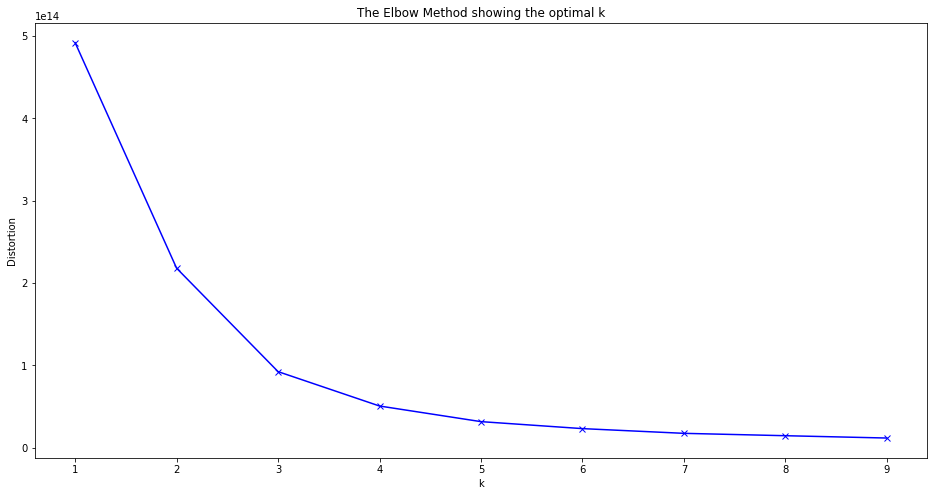

In [9]:
distortions = [] # Store results on distortions in a list
K = range(1, 10) # Initialize k
for k in K:
    kmeanModel = KMeans(n_clusters=k) # Initialize kMeans model
    kmeanModel.fit(df[["Bedroom", "Bathroom", "Building_Size", "Plot_of_Land", "Price"]]) # Fit model to dataset
    distortions.append(kmeanModel.inertia_) # Append distortions to list for each k value
# use matplotlib to plot function
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [10]:
#KneeLocator is used to compute the point of inflection
# especially when it is difficult to locate the point of inflection from the curve above

kl = KneeLocator(range(1, 10),
                 distortions,
                 curve="convex",
                 direction="decreasing")
print('The optimum number of clusters is: ' + str(kl.elbow))


The optimum number of clusters is: 3


In [23]:
#creating a KMeans cluster object
Km = KMeans(n_clusters=3)

#fix the KMeans to the dataset
Cluster = Km.fit_predict(df_clean[["Bedroom", "Bathroom", "Building_Size", "Plot_of_Land", "Price"]])
df_clean['Cluster'] = Cluster
df_clean.head()

/data/user/0/ru.iiec.pydroid3/cache/ipykernel_18571/769269177.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster'] = Cluster


,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description,Cluster
0,"Alella, Barcelona",4,3,373,1118,1790000,"Villa for sale in Alella, Barcelona",This 373sq m modern house completely renovated...,2
1,"Alella, Barcelona",6,5,639,1265,1600000,"Villa for sale in Alella, Barcelona",Located in the exclusive Can Teixido residenti...,2
2,"Alella, Barcelona",4,2,245,540,630000,"Villa for sale in Alella, Barcelona",The house is located in the upper part of Alel...,1
3,"Alella, Barcelona",3,4,604,1500,2500000,"Villa for sale in Alella, Barcelona",The luxurious mansion is located in a unique l...,2
4,"Alella, Barcelona",5,5,500,1100,1325000,"Villa for sale in Alella, Barcelona",Villa in a prestigious urbanization of Alella ...,2


In [24]:
#Get the count number of houses per cluster
df_cluster = df_clean.groupby('Cluster').count().reset_index()
df_cluster.head()


,Cluster,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description
0,0,5,5,5,5,5,5,5,5
1,1,177,177,177,177,177,177,177,177
2,2,73,73,73,73,73,73,73,73


From the data 177 house have same similarities and falls under cluster 0, 73 falls under cluster 1 and 5 in cluster 3

## Model Development


In [18]:
#Heat map diagram to analyze the correlation between between all numeric value in the data set
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_numeric = df_clean.select_dtypes(include=numerics)
df_numeric.head()

,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Longitude,Latitude,Cluster
0,4,3,373,1118,1790000,2.294276,41.495287,0
1,6,5,639,1265,1600000,2.294276,41.495287,0
2,4,2,245,540,630000,2.294276,41.495287,2
3,3,4,604,1500,2500000,2.294276,41.495287,0
4,5,5,500,1100,1325000,2.294276,41.495287,0


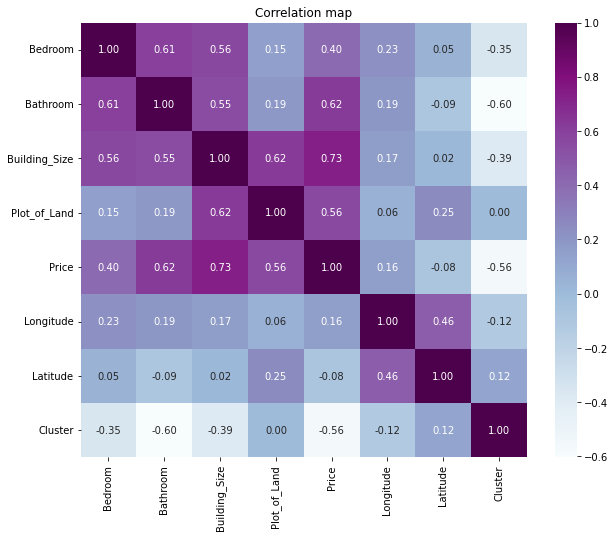

In [16]:
#I use a correlation matrix to see how the attributes relate to each other
fig = plt.figure(figsize = (10,8))
plt.title("Correlation map")
sns.heatmap(df_numeric.corr(), annot = True, fmt=".2f", cmap="BuPu")
plt.show()

from the correlation Analysis, Building_Size and Bathroom has the highest correlation effect with Price with a correlation value of 0.73 and 0.62 respectively

# Random Forest Regression

In [95]:
X = df_clean[['Bedroom', 'Bathroom', 'Building_Size', 'Plot_of_Land']]
Y = df_clean["Price"]

In [96]:
#initialize Linear Regression model
regressor = RandomForestRegressor(n_estimators=100, max_depth=7, max_leaf_nodes=32)
#split the data into 70% training and 30% testing
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=10)
#train the model with our training data 
regressor.fit(X_train,Y_train)

RandomForestRegressor(max_depth=7, max_leaf_nodes=32)

In [100]:
#predicted value of price
y_predictions = regressor.predict(X_test)
y_predictions[:5]

array([1327769.08348811,  543715.11459725, 1771948.91534308,
        477668.10509796,  139826.72748865])

In [101]:
#check the model accuracy/ performance using r square method
r_score = metrics.r2_score(y_test, y_predictions)
print(f"R Square Value: {r_score}" )

R Square Value: 0.7124223964333438


In [102]:
#check the model accuracy/ performance using Mean Square Error(MSE) and sklearn.matrics
print(f"mean squared error: {mean_squared_error (y_test, y_predictions)}")

mean squared error: 351259016212.6962


## Multiple Linear Regression

Multiple Linear Regression is very similar to Simple Linear Regression, but this method is used to explain the relationship between one continuous response (dependent) variable and two or more predictor (independent) variables

In [103]:
#initialize Linear Regression model
reg = linear_model.LinearRegression()
#split the data into 70% training and 30% testing
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=10)
#train the model with our training data 
reg.fit(x_train, y_train)

LinearRegression()

In [105]:
#predicted value of price
y_prediction = reg.predict(x_test)
y_prediction[:5]

array([1952174.35993118,  850821.09620735, 1620059.46172429,
        170861.19221474,  258818.31468125])

In [106]:
#What is the value of the intercept(a)?
reg.intercept_


-209305.18169746455

In [107]:
#What are the values of the coefficients (b1, b2, b3, b4)?
reg.coef_

array([-1.36257431e+05,  3.70853875e+05,  1.51572902e+03,  2.66810689e+00])

In [108]:
#check the model accuracy/ performance using r square method
r_score = metrics.r2_score(y_test, y_prediction)
print(f"R Square Value: {r_score}" )

R Square Value: 0.7362690206494221


In [109]:
#check the model accuracy/ performance using Mean Square Error(MSE) and sklearn.matrics
print(f"mean squared error: {mean_squared_error (y_test, y_prediction)}")

mean squared error: 322131776614.5958




Now that i have analyze the different models, and generated the R-squared and MSE values for the fits, how do i determine a good model fit?

What is a good R-squared value?

When comparing models, the model with the higher R-squared value is a better fit for the data.

What is a good MSE?

When comparing models, the model with the smallest MSE value is a better fit for the data. 
Let's take a look at the values for the different models.

RANDOM FOREST
R-squared: 0.7124223964333438
MSE:351259016212.6962

MULTIPLE LINEAR REGRESSION: 
R-squared: 0.7362690206494221
MSE:322131776614.5958

Hence comparing the two model technique , multiple linear regression model has the highest r squared value and the least mean square error, hence it's a better model for our price prediction compare to random forest model. 

## NLP Machine Model

In this section, I carried out price prediction model Analysis using the cleaned description text with tha aid of of Bag-of-words and TF-IDF model

## Standardizing the Price for sentiment analysis 

For the purposes of sentiment analysis, we will convert all of the Price into binary values(One hot  using the follow rule:

1)Price greater than the average price of the price column will be mapped as 1 and this will represent expensive houses.

2)Price lesser than the average price of the price column will be mapped as 0 and this will represent  non expensive houses



In [10]:
price_sentiment = []
for price in df_clean["Price"]:
    if price > df["Price"].mean():
        price_sentiment.append(1)
    else:
        price_sentiment.append(0)
        
df_clean["Price_sentiment"] = price_sentiment

/data/user/0/ru.iiec.pydroid3/cache/ipykernel_23778/3871778884.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Price_sentiment"] = price_sentiment


In [10]:
df_clean[["Description_new_text" , "Price", "Price_sentiment"]].head()

,Description_new_text,Price,Price_sentiment
0,this 373sq m modern house completely renovated...,1790000,1
1,located in the exclusive can teixido residenti...,1600000,1
2,the house is located in the upper part of alel...,630000,0
3,the luxurious mansion is located in a unique l...,2500000,1
4,villa in a prestigious urbanization of alella ...,1325000,1


In [12]:
expensive = len(df_clean.loc[df_clean["Price_sentiment"]==1])
not_expensive = len(df_clean.loc[df_clean["Price_sentiment"]==0])
print(f"number of expensive: {expensive}\nnumber of non expensive houses: {not_expensive}")

number of expensive: 78
number of non expensive houses: 177


hence we have a total of 78 expensive house and 178 count for non expensive houses according to the Data

## Bag-of-words

The bag-of-words procedure falls under a broader category of techniques known as count-based representations. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

I created a word-document co-occurrence matrix for the Description_new_text column using the "CountVectorizer"  class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization and furthermore used LogisticRegresssion technique to train and test the model 

In [11]:
### Creating a python object of the class CountVectorizer
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,3)) # number of n-grams

bow_data = bow_counts.fit_transform(df_clean['Description_new_text'])
#splitting the data for training and testing
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    df_clean['Price_sentiment'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes
# Training the model 
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model
## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction
## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.5555555555555556


We can even get an interpretable features form  in terms of words that  contributed the most to expensive and not so expensive sentiment:

In [12]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # get all the n-gram feature names
                                   lr_model_all.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for expensive houses

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,words,weights
38178,room,0.270080
48887,villa,0.249865
41337,sqm,0.242316
38727,rooms,0.179795
39787,service,0.178713
39306,sea,0.168035
2039,5,0.151467
5903,and,0.147514
15803,design,0.139765
30057,maresme,0.138960


In [ ]:
lr_weights.plot.bar()
plt.show()

In [70]:
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for non expensive houses

,words,weights
4942,air,-0.096590
11209,bedrooms,-0.096817
47280,town,-0.099923
12361,by,-0.100265
9591,automatic,-0.100871
30582,minutes,-0.101302
27515,la,-0.112314
36366,price,-0.114255
29241,m,-0.117507
23897,house,-0.123746


## TF-IDF 

Frequency-Inverse Document Frequency (TF-IDF) evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

In [11]:
# Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,3)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(df_clean['Description_new_text'])
#split data for testing and training
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            df_clean['Price_sentiment'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

# Setting up the model class
lr_model_tf_idf = LogisticRegression()
## Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)
## Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)
## Evaluating the model
print("F1 score: ",f1_score(y_test_tfidf, test_pred_lr_all))

F1 score:  0.16666666666666669


Comparing the two nlp modelling method, Bag-of-word model is a better model to predict texture data

#### Preview the resulting dataframe in preparation for export to Tableau

In [13]:
df_clean.head()

,Barcelona_province_locations,Bedroom,Bathroom,Building_Size,Plot_of_Land,Price,Address,Description,Longitude,Latitude,Description_new_text,Description_text_nonstop,Description_text_lemmatize,Price_sentiment
0,"Alella, Barcelona",4,3,373,1118,1790000,"Villa for sale in Alella, Barcelona",This 373sq m modern house completely renovated...,2.294276,41.495287,this 373sq m modern house completely renovated...,"[373sq, modern, house, completely, renovated, ...","[373sq, modern, completely, renovated, 2015, l...",1
1,"Alella, Barcelona",6,5,639,1265,1600000,"Villa for sale in Alella, Barcelona",Located in the exclusive Can Teixido residenti...,2.294276,41.495287,located in the exclusive can teixido residenti...,"[located, exclusive, teixido, residential, are...","[located, exclusive, teixido, residential, ale...",1
2,"Alella, Barcelona",4,2,245,540,630000,"Villa for sale in Alella, Barcelona",The house is located in the upper part of Alel...,2.294276,41.495287,the house is located in the upper part of alel...,"[house, located, upper, part, alella, enjoys, ...","[located, upper, part, alella, enjoys, impress...",0
3,"Alella, Barcelona",3,4,604,1500,2500000,"Villa for sale in Alella, Barcelona",The luxurious mansion is located in a unique l...,2.294276,41.495287,the luxurious mansion is located in a unique l...,"[luxurious, mansion, located, unique, location...","[luxurious, mansion, located, unique, one, ale...",1
4,"Alella, Barcelona",5,5,500,1100,1325000,"Villa for sale in Alella, Barcelona",Villa in a prestigious urbanization of Alella ...,2.294276,41.495287,villa in a prestigious urbanization of alella ...,"[villa, prestigious, urbanization, alella, tei...","[villa, prestigious, urbanization, alella, tei...",1


In [14]:
#remove unnecessary column from dataframe
df_clean.drop(["Description" ,"Description_text_nonstop", "Description_text_lemmatize"],axis=1)
#save to system
df_clean.to_csv("tableau.csv")
print ("save successfully")

save successfully
